# Engine Vital Signs Report

## Introduction

Analysis of engine vital signs is critical in motor racing. This notebook describes a method to summarize data imported from Marelli Wintax 4 software to provide concise reports about the engine health of vehicles competing in the Sotck Light racing category.

**Disclaimer:** This notebook uses real data from racing events selected randomly from past seasons in groups of normal and faulty data to test certain features of the algorithm. They do not represent any especific event, neither an outing represents the same group of vehicles.

## Objectives
- Read ASCII (.prn) files exported from Marelli Wintax 4 data acquisiton software;
- Reduce execution time of the algorithm: test options of data export from Wintax and how it's read in Python Pandas package;
- Find the reference point and append to a Pandas DataFrame;
- Get key indicators of minimum and maximum pressures and temperatures;
- Export a formatted excel file for easy readability during the race event;
- Summarize data in boxplots, separated per outing.

## Loading Data

First, let's import the packages and define a main working directory 'main_wd'.

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.cbook import boxplot_stats

In [2]:
main_wd = os.getcwd()
print('main_wd is at ' + main_wd)

main_wd is at C:\Users\p0092549\Documents\git\engine_vital_signs


## Function *read_data*(target_folder, method)

This function searches for all ASCII (.prn) files exported from the Marelli Wintax 4
to create a 'database'pandas DataFrame which contains raw data from all cars in a given session. 

Keyword arguments:

- target_folder -- path to the folder containing the .prn files 
- method -- pandas method to read the ASCII files (default=pd.read_table)

In [3]:
def read_data(target_folder, method=pd.read_table):
    """This function searches for all ASCII (.prn) files exported from the Marelli Wintax 4
    to create a 'database'pandas DataFrame which contains data of all cars in a given session. 
    
    Keyword arguments:
    target_folder -- path to the folder containing the .prn files 
    method -- pandas method to read the ASCII files (default=pd.read_table)
    
    There are two ways of exporting data from Marelli: all laps appended and the default method
    which exports each lap in a different file. Appended method runs much faster.
    The .prn files are named by default with the following structure:
    
    - Tr0000_Abs00000000_TeamName_CarNumber_Lap0_cableData (non appended export)
    - Append_Tr0000_Abs00000000_TeamName_CarNumber_Lap0_cableData (appended export)
    
    IMPORTANT: do not change the default file name
    """     
    database = pd.DataFrame()
    os.chdir(str(main_wd) + '\\' + target_folder)

    for file in glob.glob('*.prn'):
        data_temp = method(file, delim_whitespace=True)
        split_filename = file.split('_')
        # Adjust the index according to the export 
        if split_filename[0] == 'Append':
            index = 1
        else: 
            index = 0
        # Creates a new column with the team name
        data_temp['Team'] = split_filename[index + 2]
        data_temp['Vehicle'] = split_filename[index + 3]   
        data_temp['Session'] = target_folder  
        database = database.append(data_temp)  # Appends each file data to a database
        
    return database

Let's import raw data to see how it looks like:

In [4]:
df = read_data('data\Q')
df.head()

,Time,GainLoop,Lambda,P_Adm,P_Fuel,P_Oil,TPS,RPM,T_Air,T_Fuel,...,VehicleSpeed,Gear_Pot,P2P_Available,Learn_TPS2Max,Learn_TPS2Min,WS_FL_filt,WS_FR_filt,Team,Vehicle,Session
0,0:000,1.0,0.996,910,0.503,-0.065,31.9,0,57.1,46.6,...,0,1,0,4394,644,0.0,0.0,TeamA,03,data\Q
1,0:050,1.0,0.996,910,0.555,-0.066,31.9,99,57.1,46.6,...,0,1,0,4394,644,0.0,0.0,TeamA,03,data\Q
2,0:100,1.0,0.858,910,0.599,-0.066,31.9,94,57.1,46.6,...,0,1,0,4394,644,0.0,0.0,TeamA,03,data\Q
3,0:150,1.0,0.854,910,0.614,-0.066,31.9,77,57.1,46.6,...,0,1,0,4394,644,0.0,0.0,TeamA,03,data\Q
4,0:200,1.0,0.845,910,0.664,-0.064,31.9,97,57.1,46.6,...,0,1,0,4394,644,0.0,0.0,TeamA,03,data\Q


In the example above data comes from a qualifying session exported at 20Hz, which is the smallest file size among the sessions. Let's see how many rows the DataFrame have:

In [5]:
len(df)

194802

### Execution time performance

#### Marelli export options

There are two ways of exporting data from Marelli: 

- Appended: all laps appended into a single file; 
- Not appended (default) which exports each lap in a different file.

Which method is faster to import to a DataFrame? One large file (appended method) or several small files (default)? 
Let's roll out the numbers:

In [6]:
%timeit read_data('data_sample\\not_appended')
print('not appended method, number of files = ' + str(len(glob.glob("*.prn"))) + '\n')

%timeit read_data('data_sample\\appended')
print('appended method, number of files = ' + str(len(glob.glob("*.prn"))))

546 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
not appended method, number of files = 11

458 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
appended method, number of files = 2


The appended method outperformed by far the not appended method, which was actually expected since it reduces the number of loops in the read_data function. 

#### Pandas import options

We could also optimize the algorithm using a different method to read the data in Pandas package:

- *read_csv* and *read_table* are the most common functions to read delimited data, in this case the only difference between them is the defalut delimiter which we have changed anyway using an argument called *delim_whitespace=True*, for this reason we should not have any difference in performace. 

- *read_fwf* is another possible way to read the data. It does not use delimiters but fixed column sizes. 

Let's see if there is any difference in performance using *read_table* and *read_fwf* functions. 

In [7]:
%timeit read_data('data_sample\\appended')
print('read_table method' + '\n')

%timeit read_data('data_sample\\appended', method=pd.read_fwf)
print('read_fwf method')

453 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
read_table method

649 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
read_fwf method


## Vital Signs Reference Point

The data analysis is performed at the so-called **reference point**, which is a specific condition of the engine operating at wide open throttle (WOT) on high rpm and high vehicle speed, on the last lap of the outing. If nothing else happens, this is the critical point for the engine, since the temperatures are elevated and the engine has been stressed during the entire run. If something unespected do happen, it is caught by the **key indicators**, which are minimum and maximum values of pressures and temperatures also taken from the data after a threshold filtering process to avoid false positives.

As an axample, the figure below shows raw data of the entire qualifying outing imported previously. For the sake of simplicity, only vehicle speed, oil pressure and temperature are shown, even though the reference point would englobe all channels available related to the engine operation.

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_data(data, xlim, vehicle, ylim=(0,250), notes='off'):
    time = []
    freq = 20  # Recorded data frequency [Hz]
    for vehicles in data.Vehicle.unique():
        elapsed_time = np.arange(0,len(data[data.Vehicle == vehicles])/freq,1/freq)
        for i in range(0, len(elapsed_time)):
            time.append(elapsed_time[i])

    data['ElapsedTime'] = time
    outing = data[data['Vehicle'] == vehicle]

    sns.set(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(10,4))
    color = 'k'
    ax1.set_ylabel('Vehicle Speed [km/h]')
    ax1.set_xlabel('Time [s]')
    ax1.plot('ElapsedTime','VehicleSpeed',data=outing, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(ylim)
    if notes == 'off':
        pass
    else:
        ax1.annotate('reference point', xy=(589, 187), xytext=(586, 132), 
                     arrowprops=dict(facecolor='black', arrowstyle="simple"))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Oil Temperature [°C]') 
    ax2.plot('ElapsedTime','T_Oil',data=outing, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.label.set_color(color)
    ax2.grid(False)

    color = 'tab:red'
    ax3 = ax1.twinx()
    ax3.set_ylabel('Oil Pressure [bar]') 
    ax3.plot('ElapsedTime','P_Oil',data=outing, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.yaxis.label.set_color(color)
    ax3.spines["right"].set_position(("axes", 1.07))
    ax3.grid(False)
    ax3.set_xlim(xlim)

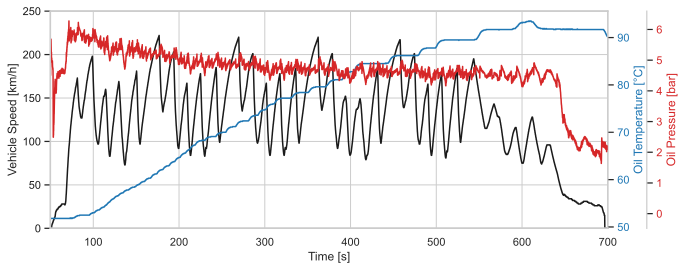

In [9]:
data = df
xlim = 50,700
plot_data(data, xlim, vehicle='00')

The figure below shows what a typical **reference point** looks like. Note that it is located at the last straight line of the outing.

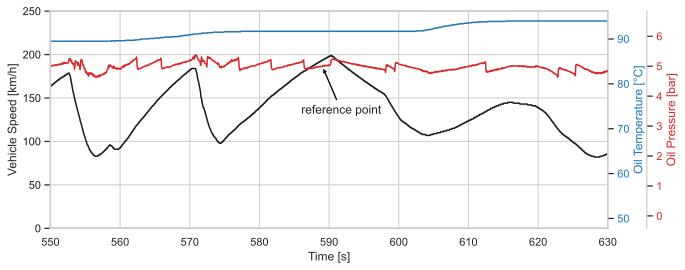

In [10]:
xlim = 550,630
plot_data(data, xlim, vehicle='01', notes='on')

The **reference point** does not indicate the point of absolute maximum temperatures or minimum pressures but the last point at which the engine is being stressed in the outing. In general, if there is something permanent wrong with the engine, such as overheating or low oil pressure, it will be shown also at this point. However, quick events such as pressures fall off's will not be catch by the reference point, that is the reason to also capture some **key indicators** from data.

The currently thresholds used for the reference point of the Stock Light are:

- Gear position: 5th to 6th gear;
- Throttle position: $\pm$ 3% TPS @ WOT;
- Pedal position: 97% to 105%;
- Engine speed: 5300 to 5400 rpm (limiter is at 5600 rpm).                       

The figure below shows the last part of a race (after a safety car intervention). It can be noted some oil pressure drops below 3 bar which are not normal for this engine. Note also that this drops would be catch only by change by the reference point. In this cases the key indicators would point out the minimum oil pressure of the outing.            

In [11]:
data = read_data('data\R1')

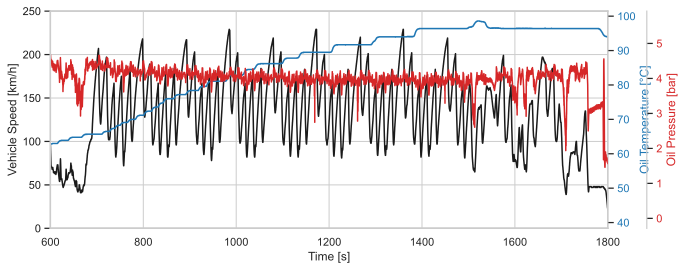

In [12]:
xlim = 600,1800
plot_data(data, xlim, vehicle='09')

The currently thresholds for the key indicators are:

- Gear position: 1st to 6th gear;
- Throttle position: $\pm$ 3% TPS @ WOT;
- Pedal position: 97% to 105%;
- Engine speed: 3000 to 5400 rpm.

## Function *filter_data*(data, threshold)

The function *filter_data*() filters the raw data imported using *read_data*(). 
The thresholds are structured in a dictionary containing minimum and maximum values for each channel of interest.

To avoid raising an error when there is a faulty data, the algorithm searches for a local minimum and maximum 
when the default thresholds cannot be not met. Then, it prints out the new threshold applied.

In [13]:
def filter_data(data, threshold, vehicle):
    """This function filters raw data imported from the Marelli Wintax 4 acording to the given thresholds.
    
    Keyword arguments:
    data -- pd.DataFrame output from the read_data() function 
    threshold -- dictionary of the thresholds to filter data {'Channel_Name':(min threshold,max_threshold), ...}
    
    To avoid raising an error when there is a faulty data, the algorithm searches for a local minimum and maximum 
    when the default thresholds cannot be not met. Then, it prints out the new threshold applied.
    """    
    threshold_list = list(threshold.keys())
    
    for parameter in threshold_list:
                    
        if (max(data[parameter]) > threshold[parameter][0]) & (min(data[parameter]) < threshold[parameter][1]):
            data = data[(data[parameter] > threshold[parameter][0]) & (data[parameter] < threshold[parameter][1])]   
          
        else:
            data = data[(data[parameter] > max(data[parameter])*0.95)]
            print('#' + str(vehicle) + ' [NOK] ' + parameter + ' max = ' + str(max(data[parameter]))
                 + ' | threshold of ' + str(max(data[parameter])*0.95) + ' applied')
            
        if len(data) == 0:
            print('#' + str(vehicle) + ' [NOK] ')
                        
    if len(data) > 0:
        print('#' + str(vehicle) + ' [OK] ' + '(' + str(len(data)) + ')')

    return data

## Function *export_data*(target_folder)

This function return a DataFrame with the reference point. It uses both *read_data*() and *filter_data*() functions. 
Thresholds were defined within the function

In [14]:
def export_data(target_folder):
    """This function returns a DataFrame cointaining the reference points and key indicators
    
    Keyword arguments:
    target_folder -- path to the folder containing the .prn files of the session of interest
    """  
    database = read_data(target_folder)
    reference_point = pd.DataFrame()
    vehicles = database.Vehicle.unique() # stores into a list all unique vehicle strings

    for vehicle in vehicles:
        # Restores database before filtering.
        data = database 

        # Gets vehicle data currently in the loop.
        data = data[data.Vehicle == str(vehicle)]

        # Identify which baseline TPS is being used in the race event, it might differ from season to season.
        # It also has to consider the push to pass feature, wich for a limited amount of time give 100% of TPS.
        average_TPS = np.average(database[(database['TPS'] < 70) & 
                                          (database['Pdl'] > 90) & 
                                          (database['VehicleSpeed'] > 100)]['TPS'])  

        # Thresholds used to target the reference point
        threshold = {'Gear_Pot':(5,7), 
                     'TPS':(average_TPS*0.97,average_TPS*1.03), 
                     'Pdl':(97,105), 
                     'RPM':(5300,5400)}  
        reference_point = reference_point.append(filter_data(data, threshold, vehicle).iloc[-1,:])

        # Thresholds used to get min and max values from the entire outing, not at the reference point.
        threshold_min_max = {'Gear_Pot':(1,7), 
                             'TPS':(average_TPS*0.97,102), 
                             'Pdl':(97,105), 
                             'RPM':(3000,5400)}
        data = filter_data(data, threshold_min_max, vehicle)  

        # Target parameters to append min and max values.
        parameters_dict = {'Min_P_Oil':min(data['P_Oil']), 
                           'Max_T_Water':max(data['T_Water']), 
                           'Max_T_Oil':max(data['T_Oil']),
                           'Min_P_Fuel':min(data['P_Fuel']), 
                           'Max_VehicleSpeed':max(data['VehicleSpeed']), 
                           'Max_TPS':max(data['TPS'])}

        # Search for the Vechile currently in the loop to append the min or max values.
        for parameter in list(parameters_dict.keys()):
            reference_point.loc[(reference_point.Vehicle == str(vehicle)), parameter] = parameters_dict[parameter]

        # Calculates 'TPS_learn_Status': (Learn_TPS2 manually stored in 'Learn_TPS.xlsx' - Learn_TPS2 recorded from data).
        os.chdir(main_wd) # changes the cwd to the main_wd
        Learn_TPS = pd.read_excel("Learn_TPS.xlsx")
        
        if len(Learn_TPS['Vehicle'].isin([int(vehicle)]).unique()) == 1:
            print('Learn_TPS values not found for vehicle ' + str(vehicle))
        else:
            for TPS2MinMax in ['Learn_TPS2Min','Learn_TPS2Max']:
                Learn_TPS_Status = (int(Learn_TPS[Learn_TPS['Vehicle'] == int(vehicle)][TPS2MinMax]) 
                                    - int(reference_point[reference_point['Vehicle'] == (vehicle)][TPS2MinMax]))
                # Append 'Learn_TPS_Status' to the reference_point DataFrame
                reference_point.loc[(reference_point.Vehicle == str(vehicle)), (TPS2MinMax + str('_Status'))] = Learn_TPS_Status
                
    return reference_point

### Extracting reference points and key indicators from raw data

With the *export_data*() function we can extract the reference points and key indicators:

In [15]:
reference_point = export_data('data\R1')

#02 [OK] (277)
#02 [OK] (24946)
#03 [NOK] RPM max = 5194 | threshold of 4934.3 applied
#03 [OK] (83)
#03 [OK] (1659)
#04 [OK] (239)
#04 [OK] (26998)
#05 [OK] (287)
#05 [OK] (23539)
#06 [OK] (372)
#06 [OK] (29657)
#07 [OK] (114)
#07 [OK] (12881)
#08 [OK] (348)
#08 [OK] (26376)
#09 [OK] (167)
#09 [OK] (16368)
#00 [OK] (235)
#00 [OK] (26063)
#01 [OK] (235)
#01 [OK] (26063)


In the log above we can see that *filter_data*() function has behaviour as expected with the faulty data of the vehicle #00 which did not met the engine speed threshold of 5300 rpm. Istead, the local minimum was used as a baseline to the new threshold which is 95% of the local minimum.

### Excel formated export

This code exports the *reference_point* DataFrame into a formated excel worksheet. The conditional formating are grouped by two types: channels with well defined range of operation (type A) and channels with wide range with operation which the median depends on external factors such as ambient temperatures (type B).

- Type A: conditional formating follows a user defined upper and lower limit; thresholds are defined within the function;
- Type B: the top five values are highlighted in red. 

The aim of this file is to provide concise information about the healthy of the racecars. It is the first approach for a more in depth data analysis of faulty data which is performed at the Marelli Wintax software.

In [16]:
def excel_report(target_folder):
    
    reference_point, average_TPS = export.preprocessing(target_folder)    
    
    # Not all columns of the raw data are going into the final report so we have to list which one are going to be used:
    columns = export.config.columns
    
    writer = pd.ExcelWriter(str('reference_point_TESTE' + str(target_folder.split(sep='/')[1]) + '.xlsx'), engine='xlsxwriter')
    reference_point.to_excel(writer, columns = columns, index = False)
    #reference_point.to_excel(writer)
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    
    # Add a format. Red / Green
    format = [workbook.add_format({'bg_color': '#FFC7CE','font_color': '#9C0006'}),
              workbook.add_format({'bg_color': '#C6EFCE','font_color': '#006100'})]
    thresholds = {'T_Water':(50,90),
              'T_Oil':(50,105), 
              'P_Oil':(3,5.5),
              'P_Fuel':(3.1,4), 
              'Lambda':(0.8,0.84),
              'Lambda2':(0.75,0.85), 
              'GainLoop':(0.93,1.07), 
              'Vbatt':(11.5,14), 
              'Pdl':(99,101.5),
              'TPS':(average_TPS*0.98,average_TPS*1.02),
              'Min_P_Oil':(3,5.5), 
              'Max_T_Water':(50,95),
              'Max_T_Oil':(50,110), 
              'Min_P_Fuel':(3.1,4), 
              'P2P_Available':(0.5,50), 
              'Learn_TPS2Min_Status':(-1,1),
              'Learn_TPS2Max_Status':(-1,1)}
    
    i = 0
    for column in columns:
        if column in thresholds:
            worksheet.conditional_format(1,i, len(reference_point),i, {'type': 'cell', 
                                                                       'criteria': 'between',
                                                                       'minimum': thresholds[column][0],
                                                                       'maximum': thresholds[column][1],
                                                                       'format': format[1]})
    
            worksheet.conditional_format(1,i, len(reference_point),i, {'type': 'cell',
                                                                       'criteria': 'not between',
                                                                       'minimum': thresholds[column][0],
                                                                       'maximum': thresholds[column][1],
                                                                       'format': format[0]})         
        else:
            worksheet.conditional_format(1,i, len(reference_point),i, {'type': 'top',
                                                                       'value':  5, 
                                                                       'format': format[0]})
        i += 1
        
    worksheet.autofilter(0,0, len(reference_point),len(columns)-1)
    writer.save()

The outuput file is structured as follows:

In [17]:
pd.read_excel('reference_point_R2.xlsx')

,Team,Vehicle,Session,T_Air,T_Water,T_Oil,P_Oil,T_Fuel,P_Fuel,Lambda,...,Max_T_Oil,Min_P_Fuel,Max_VehicleSpeed,P2P_Available,Max_TPS,Learn_TPS2Min,Learn_TPS2Min_Status,Learn_TPS2Max,Learn_TPS2Max_Status,Advance
0,TeamA,1,R2,33.8,78.4,81.1,4.924,32.9,3.618,1.146,...,93.5,3.417,215,5,99.8,644,-15,4394,0,NaN
1,TeamA,2,R2,33.2,87.8,98.7,4.424,38.5,3.550,1.000,...,98.7,3.478,216,9,100.0,634,0,4355,0,NaN
2,TeamA,3,R2,31.6,77.0,110.8,4.576,43.6,3.404,0.823,...,114.6,3.247,213,1,99.7,629,0,4399,0,NaN
3,TeamB,4,R2,32.6,81.1,114.9,4.269,46.7,3.421,0.825,...,116.4,3.317,219,2,100.0,629,5,4426,-71,NaN
4,TeamB,5,R2,34.1,85.0,117.1,4.499,46.3,3.606,0.816,...,124.2,3.530,214,1,99.4,664,-35,4428,-2,NaN
5,TeamB,6,R2,42.0,74.8,96.4,3.932,31.0,5.686,1.000,...,98.4,0.860,210,6,100.0,624,40,4422,6,NaN
6,TeamC,7,R2,31.0,74.7,116.2,5.097,40.9,3.491,0.822,...,119.1,3.377,218,1,100.0,609,15,4396,26,NaN
7,TeamC,8,R2,31.9,85.0,104.5,5.560,44.0,3.257,0.826,...,104.5,3.203,213,6,99.8,624,0,4401,0,NaN
8,TeamC,9,R2,35.9,86.6,67.2,4.266,36.0,3.505,0.815,...,69.0,3.478,200,8,62.4,629,0,4370,0,NaN
9,TeamA,0,R2,33.2,74.9,107.5,4.257,49.4,3.731,0.820,...,107.5,3.518,217,0,99.8,610,5,4351,4,NaN


### Box Plot

This code exports a boxplot of the reference point for each outing. The aim of this plot is to give an overview of the healthy of all vehicles at once in a given session and, after the event comes to the end, a concise report alongside the excel files containing the reference point and key indicators.

The boxplot indicates the median, at the center of the interquartile range $(IQR)$, the first $(Q1)$ and third $(Q3)$ quartile and the maximum and minimum tickers, defined as $(Q1 \mbox{ or } Q3) + 1.5\times IQR$. The values ouside min/max tickers are classified as *outilers* and have the number of the car printed in the plot to highlight possible faulty data.

In [18]:
data = pd.DataFrame()

for file in glob.glob('reference_point*'):
    data = pd.concat([data,pd.read_excel(file)])

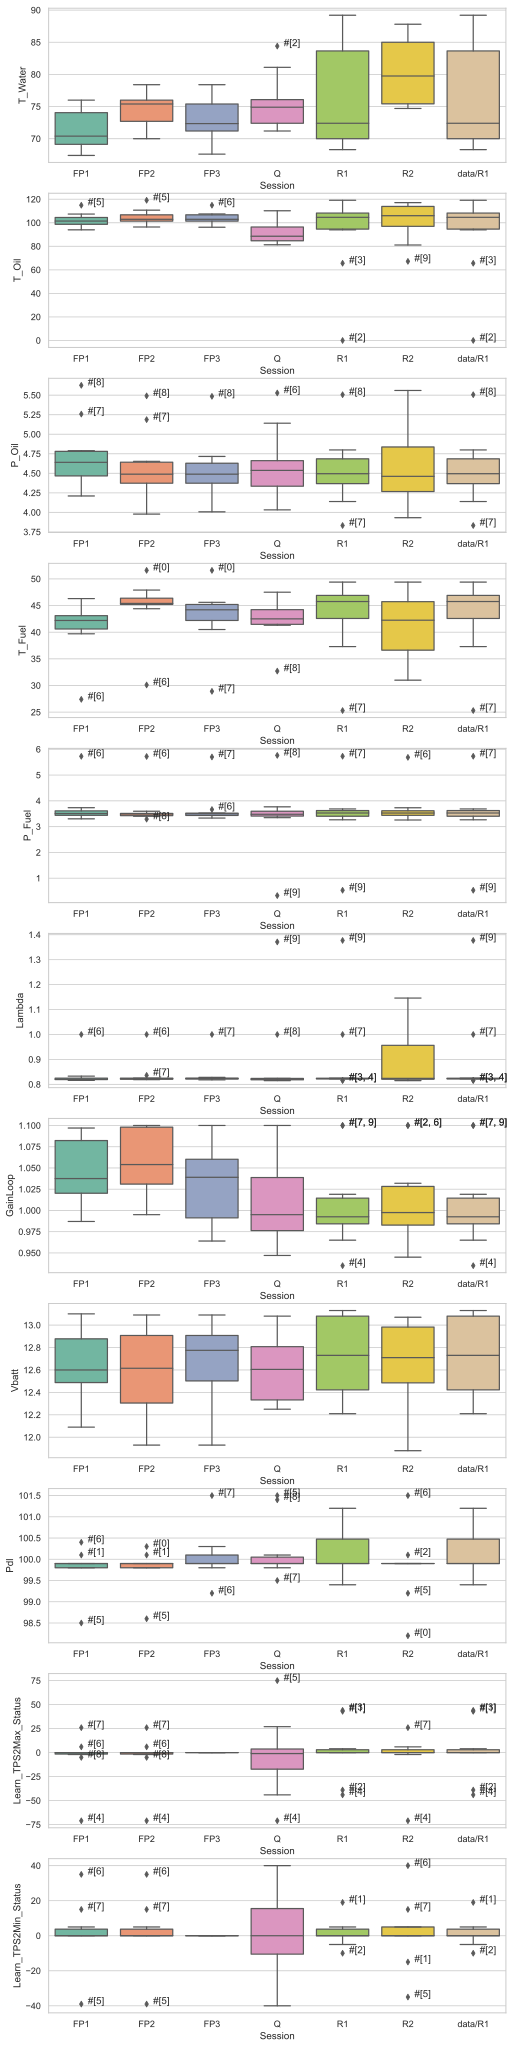

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

yaxis = ['T_Water', 
         'T_Oil',
         'P_Oil',
         'T_Fuel',
         'P_Fuel', 
         'Lambda', 
         'GainLoop',
         'Vbatt',
         'Pdl',
         'Learn_TPS2Max_Status',
         'Learn_TPS2Min_Status']

fig, axes = plt.subplots(len(yaxis),1, figsize=(10,45))
sns.set(style="whitegrid")
session_list = list(data.Session.unique())

i = 0
for parameter in yaxis:
    axes[i] = sns.boxplot(x='Session', y=parameter, data=data, ax=axes[i], palette="Set2")
          
    # Loop through each session:
    for session in range(0, len(session_list)):   
        data_loop = data  # Restores data  
        # Gets the fliers (outliers of the boxplot) for each session:
        data_loop = data[data['Session'] == session_list[session]]
        fliers = boxplot_stats(data_loop[data_loop['Session'] == session_list[session]][parameter]).pop(0)['fliers']       
        # Loops through each vehicle to find the correspoding outlier
        for vehicle_loop in range(0, len(fliers)):
            # Gets the corresponding vehicle for each outlier
            vehicle = data_loop[data_loop[parameter] == fliers[vehicle_loop]]['Vehicle']
            outlier = list(data_loop[data_loop[parameter] == fliers[vehicle_loop]][parameter])
            axes[i].annotate(('#' + str(list(vehicle))), (session + 0.1, outlier[0]))

    i += 1


In [20]:
fig.savefig('example.png', dpi=300)

## Conclusions

In this notebook we have imported raw data from a race event and exported into a formated excel file the **reference point** and **key indicators** of each racecar for each session of the event. Besides, we have exported statistical information about the race event in a boxplot format.

**Disclaimer:** the conclusions below are a personal point of view and were drawn from the personal and team experience of using and developing the algorithm for the past two racing seasons. It is not intended to be incisive conclusions but rather to give an inside on how reports of racing engines could be done. 

- The reports do not substitute analysis of faulty data on the data acquisition software;
- The main point of the report is to indicate faulty data and save the time spent on analysis of healthy vehicles to analyse more in depth the problematic vehicles;
- If the process of generate the report is slower than it is to analyse each car on the data acquisition software, it is not worthy to generate the reports between outings;
- The reports are of great value to condense information for future consulting. Very often information about the engines are requested during maintenance and the reports provides a quick overlook of the healthiness without have to open each data.

Further work are related on how faulty data is detected. Thresholds and static rules are keen to break, which lead us to work on machine learning techniques to detect abnormal data, specially clustering and ensemble of classifiers. 